In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [2]:
# Load csv file into DataFrame
data = pd.read_csv('data//WeeklyNumberofDengueandDengueHaemorrhagicFeverCases.csv')

In [3]:
# Explore Data
data.head()

,year,eweek,type_dengue,number
0,2014,1,Dengue,436.0
1,2014,1,DHF,1.0
2,2014,2,Dengue,479.0
3,2014,2,DHF,0.0
4,2014,3,Dengue,401.0


In [4]:
# Display Data Information
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         530 non-null    int64  
 1   eweek        530 non-null    int64  
 2   type_dengue  530 non-null    str    
 3   number       522 non-null    float64
dtypes: float64(1), int64(2), str(1)
memory usage: 19.0 KB


In [5]:
# Display Statistical Summary
data.describe()

,year,eweek,number
count,530.00000,530.00000,522.000000
mean,2016.00000,27.00000,93.400383
std,1.41555,15.31151,145.737645
min,2014.00000,1.00000,0.000000
25%,2015.00000,14.00000,0.000000
50%,2016.00000,27.00000,14.000000
75%,2017.00000,40.00000,155.500000
max,2018.00000,53.00000,888.000000


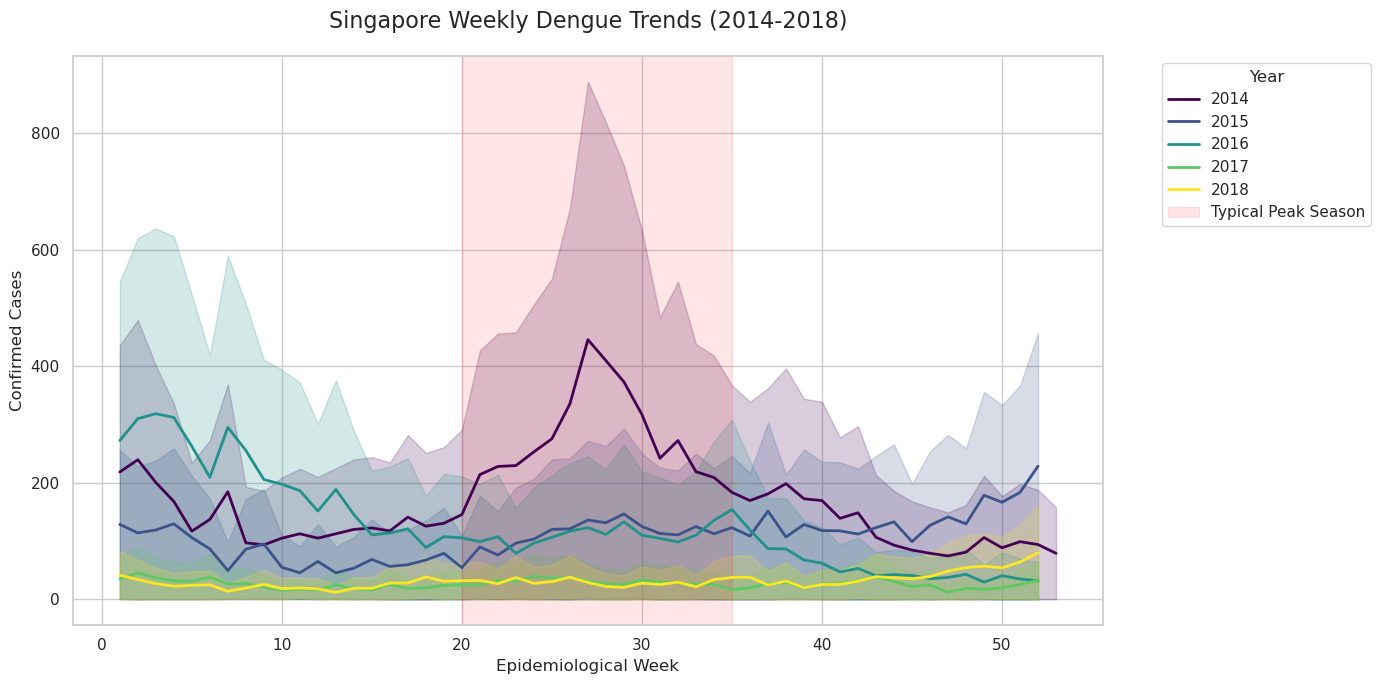

In [6]:
# 1. Set a professional style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 7))

# 2. Use a lineplot with color palette (e.g., Viridis or colorblind-friendly)
ax = sns.lineplot(data=data, x='eweek', y='number', hue='year', palette='viridis', linewidth=2)

# 3. Add context - Singapore's typical 'Dengue Season' usually starts mid-year
plt.axvspan(20, 35, color='red', alpha=0.1, label='Typical Peak Season')

# 4. Clean up labels
plt.title('Singapore Weekly Dengue Trends (2014-2018)', fontsize=16, pad=20)
plt.xlabel('Epidemiological Week', fontsize=12)
plt.ylabel('Confirmed Cases', fontsize=12)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

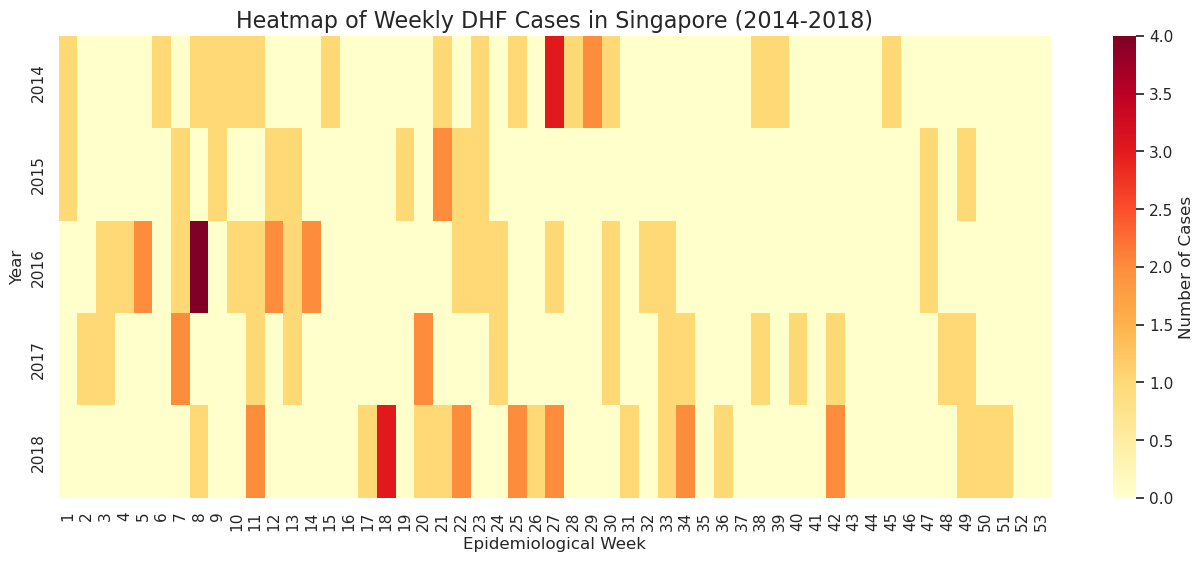

In [7]:
# 1. Prepare data for heatmap
# Create pivot_dhf: index=eweek, columns=year, values=number for DHF cases
pivot_dhf = (
	data[data['type_dengue'] == 'DHF']
	.pivot_table(index='eweek', columns='year', values='number', aggfunc='sum')
	.sort_index()
)

# If there are missing week/year combinations, replace NaNs with 0
pivot_dhf = pivot_dhf.fillna(0)

if pivot_dhf.empty:
	raise ValueError("pivot_dhf is empty — no rows with type_dengue == 'DHF' found in 'data'.")

plt.figure(figsize=(16, 6))
sns.heatmap(pivot_dhf.T, cmap="YlOrRd", annot=False, cbar_kws={'label': 'Number of Cases'})

plt.title('Heatmap of Weekly DHF Cases in Singapore (2014-2018)', fontsize=16)
plt.xlabel('Epidemiological Week')
plt.ylabel('Year')
plt.show()

In [8]:
import geopandas as gpd

# Load your GeoJSON file
gdf_geojson = gpd.read_file('data//Dengue Clusters (GEOJSON).geojson')

# Explore like a normal dataframe
print(gdf_geojson.head())
print(gdf_geojson.columns) # Look for 'LOCALITY', 'CASE_SIZE', and 'geometry'

   OBJECTID                                     LOCALITY  CASE_SIZE  \
0    508810             Elizabeth Dr / Jln Intan, Zamrud          5   
1    508811                                    Jln Jarak          2   
2    508812  Pine Gr (Nava Grove) / Pine Gr (Pine Grove)          7   
3    508813                   Simei St 1 (Blk 110, 116)           2   
4    508814                    Lor 2 Toa Payoh (Blk 122)          3   

             NAME                                          HYPERLINK  \
0  Dengue_Cluster  https://www.nea.gov.sg/dengue-zika/dengue/deng...   
1  Dengue_Cluster  https://www.nea.gov.sg/dengue-zika/dengue/deng...   
2  Dengue_Cluster  https://www.nea.gov.sg/dengue-zika/dengue/deng...   
3  Dengue_Cluster  https://www.nea.gov.sg/dengue-zika/dengue/deng...   
4  Dengue_Cluster  https://www.nea.gov.sg/dengue-zika/dengue/deng...   

                                               HOMES  \
0                                                NaN   
1                           

In [9]:
gdf_geojson.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   OBJECTID            5 non-null      int32   
 1   LOCALITY            5 non-null      str     
 2   CASE_SIZE           5 non-null      int32   
 3   NAME                5 non-null      str     
 4   HYPERLINK           5 non-null      str     
 5   HOMES               1 non-null      str     
 6   PUBLIC_PLACES       1 non-null      str     
 7   CONSTRUCTION_SITES  1 non-null      str     
 8   INC_CRC             5 non-null      str     
 9   FMEL_UPD_D          5 non-null      str     
 10  SHAPE.AREA          5 non-null      float64 
 11  SHAPE.LEN           5 non-null      float64 
 12  geometry            5 non-null      geometry
dtypes: float64(2), geometry(1), int32(2), str(8)
memory usage: 1.3 KB


In [10]:
import folium
import geopandas as gpd

# 1. Ensure the data is in the correct Coordinate System (WGS84) for web maps
gdf = gpd.read_file('data//Dengue Clusters (GEOJSON).geojson')
if gdf.crs != "EPSG:4326":
    gdf = gdf.to_crs(epsg=4326)

# 2. Initialize the map centered on Singapore
m = folium.Map(location=[1.3521, 103.8198], zoom_start=12, tiles='CartoDB positron')

# 3. Add the GeoJSON clusters to the map
folium.GeoJson(
    gdf,
    name='Dengue Clusters',
    style_function=lambda feature: {
        'fillColor': 'red' if feature['properties']['CASE_SIZE'] > 5 else 'orange',
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.6,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['LOCALITY', 'CASE_SIZE', 'CONSTRUCTION_SITES'],
        aliases=['Location:', 'Number of Cases:', 'Construction Sites:'],
        localize=True
    )
).add_to(m)

# 4. Save and display
m.save('Singapore_Dengue_Map.html')
m

In [13]:
# KML support might need to be explicitly enabled depending on your version
import fiona
fiona.drvsupport.supported_drivers['KML'] = 'rw'

gdf_kml = gpd.read_file('data//Dengue Clusters (KML).kml', driver='KML')
print(gdf_kml.head())

      id            Name                                        description  \
0  kml_1  Dengue_Cluster  <center><table><tr><th colspan='2' align='cent...   
1  kml_2  Dengue_Cluster  <center><table><tr><th colspan='2' align='cent...   
2  kml_3  Dengue_Cluster  <center><table><tr><th colspan='2' align='cent...   
3  kml_4  Dengue_Cluster  <center><table><tr><th colspan='2' align='cent...   
4  kml_5  Dengue_Cluster  <center><table><tr><th colspan='2' align='cent...   

  timestamp begin end altitudeMode  tessellate  extrude  visibility  ...  \
0       NaT   NaT NaT         None          -1        0          -1  ...   
1       NaT   NaT NaT         None          -1        0          -1  ...   
2       NaT   NaT NaT         None          -1        0          -1  ...   
3       NaT   NaT NaT         None          -1        0          -1  ...   
4       NaT   NaT NaT         None          -1        0          -1  ...   

                                            LOCALITY CASE_SIZE  \
0 

In [14]:
import geopandas as gpd
import fiona

# 1. Enable KML driver
fiona.drvsupport.supported_drivers['KML'] = 'rw'

# 2. Load the KML file
# Note: KMLs can have multiple layers; usually, the first layer contains the data
gdf_kml = gpd.read_file('data//Dengue Clusters (KML).kml', driver='KML')

# 3. Clean the 'CONSTRUCTION_SITES' column
# Sometimes KML 'None' values are strings or NaN; we handle both
construction_clusters = gdf_kml[
    gdf_kml['CONSTRUCTION_SITES'].notna() & 
    (gdf_kml['CONSTRUCTION_SITES'].str.strip() != "") & 
    (gdf_kml['CONSTRUCTION_SITES'].str.lower() != "none")
].copy()

# 4. Calculate Correlation Insights
total_clusters = len(gdf_kml)
const_count = len(construction_clusters)
avg_case_size_all = gdf_kml['CASE_SIZE'].astype(float).mean()
avg_case_size_const = construction_clusters['CASE_SIZE'].astype(float).mean()

print(f"Total Clusters: {total_clusters}")
print(f"Clusters near Construction Sites: {const_count} ({ (const_count/total_clusters)*100:.1f}%)")
print(f"Average Case Size (Overall): {avg_case_size_all:.2f}")
print(f"Average Case Size (Construction): {avg_case_size_const:.2f}")

# 5. Display top construction clusters
print("\nTop Construction-Related Clusters:")
print(construction_clusters[['LOCALITY', 'CASE_SIZE', 'CONSTRUCTION_SITES']].sort_values(by='CASE_SIZE', ascending=False).head())

Total Clusters: 42
Clusters near Construction Sites: 3 (7.1%)
Average Case Size (Overall): 22.36
Average Case Size (Construction): 37.00

Top Construction-Related Clusters:
                                             LOCALITY CASE_SIZE  \
18  Lor 1 Toa Payoh (Blk 158, 159, 160, 161, 163, ...        67   
2                                       Science Pk Dr        22   
4   Cardiff Gr (Cardiff Residence) / Golden Dr, Wa...        22   

    CONSTRUCTION_SITES  
18    Hollow metal rod  
2         Canvas sheet  
4   Pail, Canvas sheet  


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))

# 1. Create the plot
ax = sns.boxplot(x='is_construction', y='CASE_SIZE', data=gdf_kml, palette='Set2', showfliers=False)
sns.stripplot(x='is_construction', y='CASE_SIZE', data=gdf_kml, color=".3", alpha=0.5)

# 2. Set Y-axis to Log Scale
ax.set_yscale("log")

# 3. Add clean gridlines for the log scale
plt.grid(True, which="both", ls="-", alpha=0.2)

plt.title('Dengue Case Distribution (Log Scale)', fontsize=14)
plt.ylabel('Number of Cases (Log Scale)', fontsize=12)
plt.show()

ValueError: Could not interpret value `is_construction` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>

In [ ]:
# Calculate quartiles for both groups
stats = gdf_kml.groupby('is_construction')['CASE_SIZE'].describe(percentiles=[.25, .5, .75])
print("Distribution Statistics (Quartiles):")
print(stats[['25%', '50%', '75%', 'max']])

Distribution Statistics (Quartiles):
                  25%   50%   75%    max
is_construction                         
False             2.0   3.0   7.0  319.0
True             22.0  22.0  44.5   67.0
